In [1]:
!date

Mon Mar  2 15:31:45 PST 2020


# Make 10x TSNE

In [2]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as scanp
from scipy.stats import ks_2samp, ttest_ind
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [3]:
adata = anndata.read_h5ad("../cell_ranger_annotation/10xv3_gene.h5ad")

In [4]:
adata.X = adata.X.todense()

# Filter

In [5]:
num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 250
disp_threshold = 1

mito_criteria = 21.5

n_top_genes = 5000

n_bins = 20

flavor="seurat"

scale_clip = 10

### Adding info to rows/cols

In [6]:
gene = adata.copy()

In [7]:
# Writing cell_TPM, gene_TPM, n_genes, and percent_mito for each cell
gene.obs["cell_counts"] = gene.X.sum(1)
gene.var["gene_counts"] = np.asarray(gene.X.sum(0)).reshape(-1)
mito_genes = adata.var_names.str.startswith('mt-')
gene.obs["percent_mito"] = gene[:,mito_genes].X.sum(axis=1)/gene.X.sum(axis=1)*100
gene.obs["n_genes"] = (gene.X>0).sum(axis=1)

In [8]:
# For each gene, compute the dispersion and store it
mtx = gene.X
mean = np.asarray(mtx.mean(axis=0)).reshape(-1)
var = np.asarray(np.power(mtx,2).mean(axis=0)).reshape(-1) - mean**2

dispersion = var / mean

In [9]:
gene.var["dispersion"] = dispersion
gene.var["pass_disp_filter"] = gene.var["dispersion"] > disp_threshold

In [10]:
gene.var["pass_disp_filter"].sum()

24709

In [11]:
gene.obs["pass_count_filter"] = gene.obs["cell_counts"] > cell_threshold

In [12]:
gene.obs["pass_count_filter"].sum()

94162

### Filtering

In [13]:
gene.shape

(94162, 31053)

In [14]:
gene_disp_mask = gene.var["pass_disp_filter"].values
gene_cell_mask = gene.obs["pass_count_filter"].values

In [15]:
print(gene_cell_mask.sum(), gene_disp_mask.sum())

94162 24709


In [16]:
gene = gene[gene_cell_mask, gene_disp_mask]

In [17]:
print(gene.shape)

(94162, 24709)


In [18]:
mito_mask = (gene.obs.percent_mito < mito_criteria).values

In [19]:
mito_mask.sum()

90031

In [20]:
gene = gene[mito_mask,:]

In [21]:
print(gene.shape)

(90031, 24709)


In [22]:
gene

View of AnnData object with n_obs × n_vars = 90031 × 24709 
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter'
    var: 'gene_name', 'gene_id', 'gene_short_name', 'gene_counts', 'dispersion', 'pass_disp_filter'

In [23]:
gene.X

ArrayView([[ 0.,  0.,  0., ..., 29., 18.,  8.],
           [ 0.,  1.,  0., ..., 30., 26., 25.],
           [ 0.,  0.,  0., ..., 29., 22., 20.],
           ...,
           [ 0.,  0.,  0., ..., 44., 37., 34.],
           [ 0.,  1.,  0., ..., 23., 27., 22.],
           [ 0.,  1.,  0., ...,  6., 26., 23.]], dtype=float32)

### Adding info to matrices

In [24]:
gene.layers["norm"] = normalize(gene.X, norm='l1', axis=1)*1000000

In [25]:
gene.layers["log1p"] = np.log1p(gene.layers["norm"])

In [26]:
gene.X = csr_matrix(gene.layers["log1p"])
gene.layers["norm"] = csr_matrix(gene.layers["norm"])
gene.layers["log1p"] = csr_matrix(gene.layers["log1p"])

In [27]:
tmp = gene.copy()

In [28]:
scanp.pp.log1p(tmp)

In [29]:
d = tmp.uns

In [30]:
gene.uns = d

### Highly Variable Genes

In [31]:
scanp.pp.highly_variable_genes(gene, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = gene.var.highly_variable.values

### Scaling data to unit variance, zero mean for clustering

In [32]:
from sklearn.preprocessing import scale

In [33]:
%%time
mat = gene.layers["log1p"].todense()
mtx = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
gene.X = mtx

CPU times: user 1min 16s, sys: 33 s, total: 1min 49s
Wall time: 1min 49s


## **START CHECKPOINT**

In [79]:
# gene = tmp_gene.copy()
# isoform = tmp_isoform.copy()

In [36]:
gene

AnnData object with n_obs × n_vars = 90031 × 24709 
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter'
    var: 'gene_name', 'gene_id', 'gene_short_name', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    layers: 'norm', 'log1p'

In [40]:
from sklearn.decomposition import TruncatedSVD


In [41]:
# PCA

num_PCA = 50

X = gene.X[:,hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
Y = tsvd.fit_transform(X)

In [42]:
XX = Y
tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
YY = tsne.fit_transform(XX)

In [53]:
gene.obsm["X_tsne"] = YY

In [52]:
gene.obs.subclass_label.unique().tolist()

['Low Quality',
 'L6 IT',
 'L5/6 NP',
 'L5 IT',
 'L2/3 IT',
 'L6 CT',
 'Sncg',
 'Vip',
 'Lamp5',
 'Sst',
 'L5 ET',
 'Oligo',
 'L6b',
 'doublet',
 'L6 IT Car3',
 'Macrophage',
 'OPC',
 'Endo',
 'Astro',
 'VLMC',
 'Pvalb',
 'SMC']

In [60]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 ET" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  )  # bcbddc
}

cluster_order = [
    "Lamp5",
    "Sncg",
    "Vip",
    "Sst",
    "Pvalb",
    "L5 IT",
    "L5/6 NP",
    "L5 ET",
    "L2/3 IT",
    "L6b",
    "VLMC",
    "L6 IT",
    "L6 CT",
    "L6 IT Car3",
    "Endo",
    "Astro",
    "SMC",
    "Macrophage",
    "OPC",
    "Oligo",
    "doublet",
    "Low Quality"
]
cluster_cmap["doublet"] = (0.4588235294117647,  0.4196078431372549,  0.6941176470588235  )  # 756bb1
cluster_cmap["Macrophage"] =     (0.6196078431372549,  0.6039215686274509,  0.7843137254901961  )  # 9e9ac8
cluster_cmap["OPC"] =     (0.7372549019607844,  0.7411764705882353,  0.8627450980392157  )  # bcbddc
cluster_cmap["Oligo"] =     (0.8549019607843137,  0.8549019607843137,  0.9215686274509803  )  # dadaeb

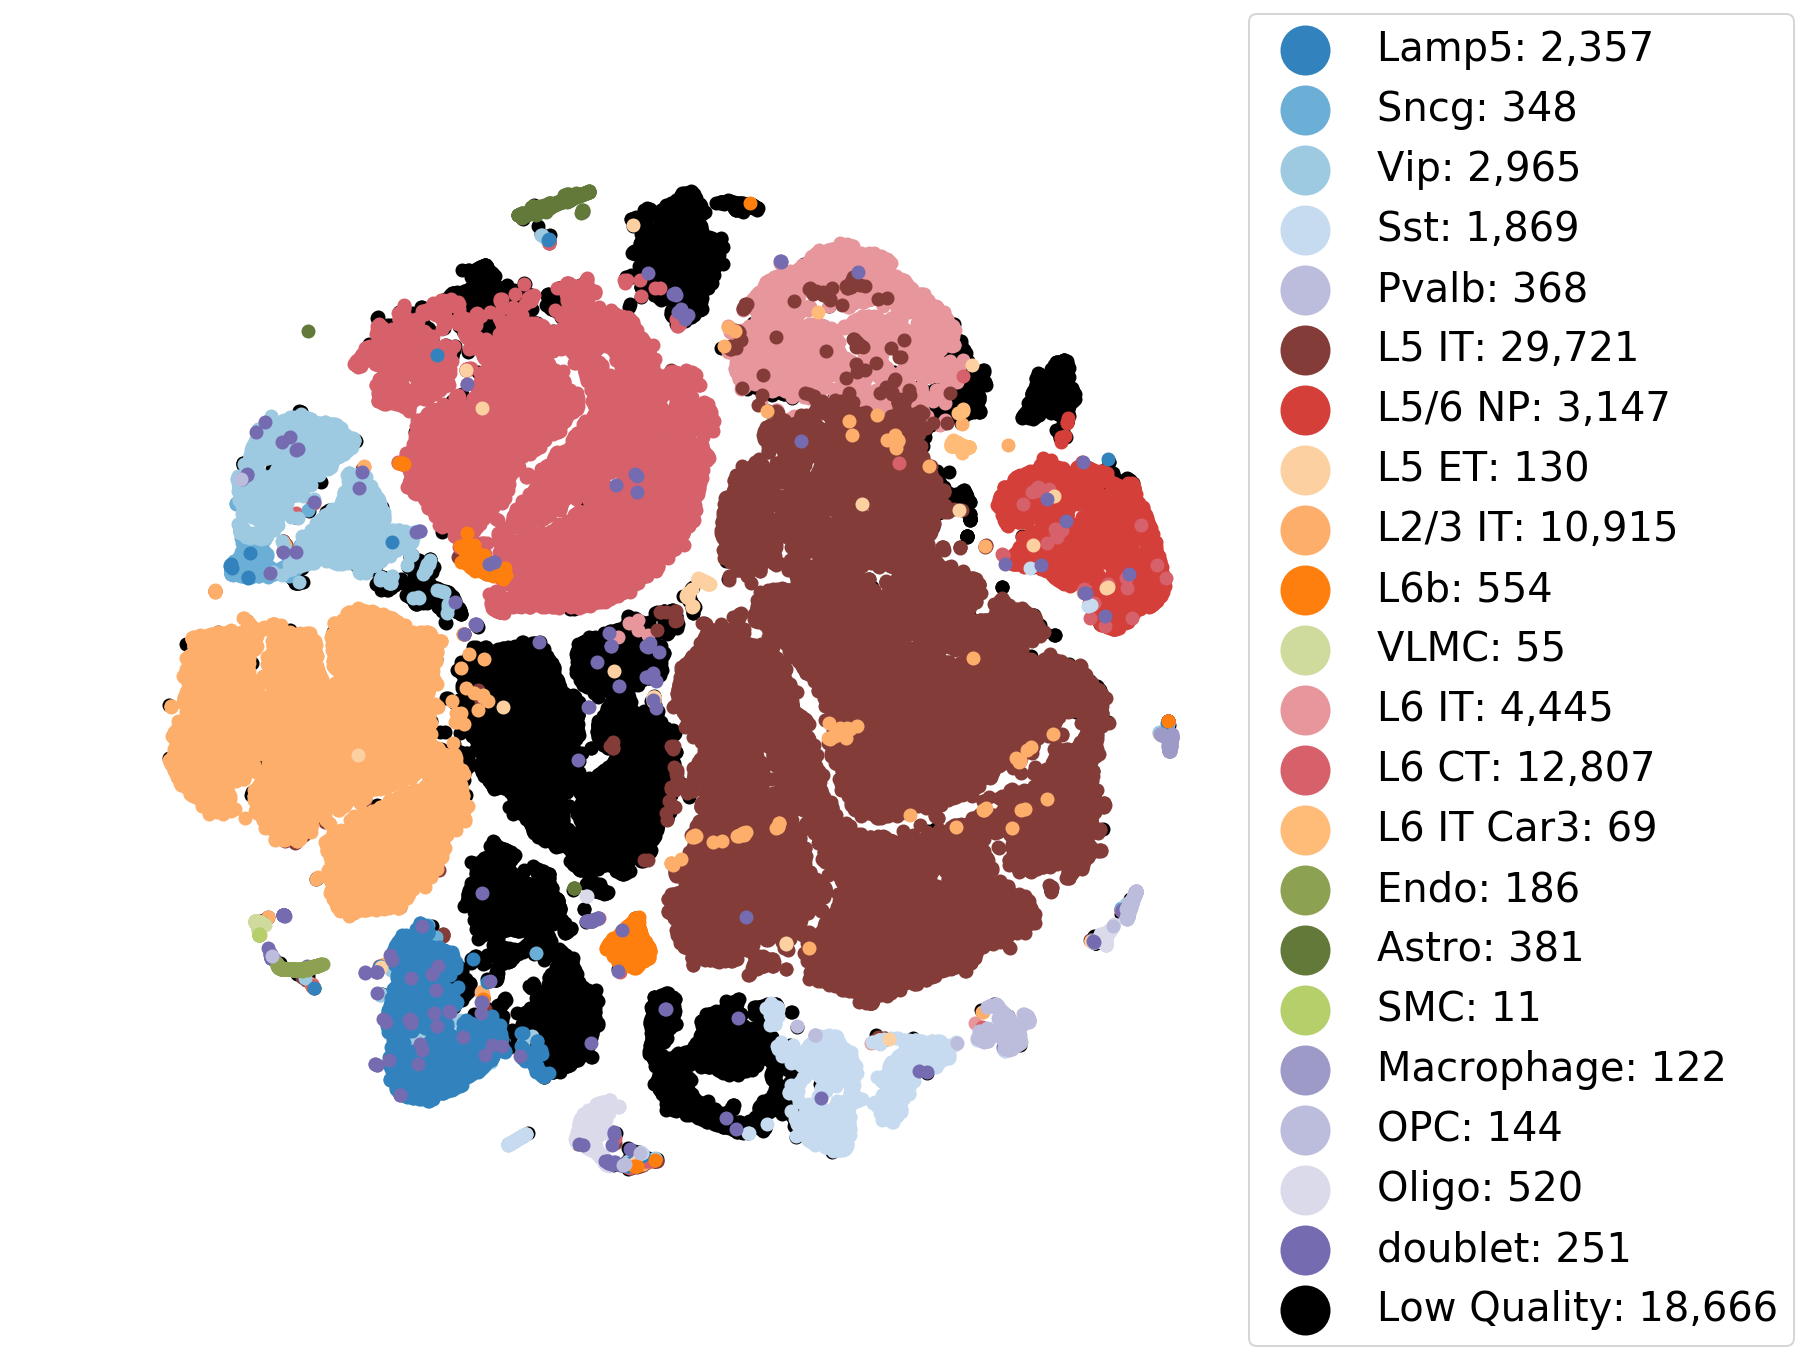

In [63]:
fig, ax = plt.subplots(figsize=(10,10))

c = gene.obs["subclass_label"].unique().astype(str)
cmap = cm.get_cmap("tab20")

for idx, cluster in enumerate(c):
    XX = gene[gene.obs.subclass_label == cluster,:].obsm["X_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    
    color = cluster_cmap[cluster]
    
    ax.scatter(x, y, color = color, label=cluster+": {:,}".format(x.shape[0]))
    # if cluster == "Endo": y = y-5; x=x+5
    # if cluster == "SMC": y = y+5; x=x+2
    # if cluster == "VLMC": x=x-20; y=y-5
    # if cluster == "L6 IT Car3": x = x+10;y=y-20
    # if cluster == "Astro": x=x-10;y=y-10
    # if cluster == "Sncg": x = x+5; y = y-5
    # ax.annotate(cluster, 
    #          (np.mean(x), np.mean(y)),
    #          horizontalalignment='center',
    #          verticalalignment='center',
    #          size=15, weight='bold',
    #          color="white",
    #            backgroundcolor=color) 
    

handles, labels = ax.get_legend_handles_labels()
idx = [np.where(c==i)[0][0] for i in cluster_order]
handles = np.array(handles)[idx]
labels=np.array(labels)[idx]

ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), markerscale=4)
ax.set_axis_off()

plt.savefig("./figures/10x_subclass_nca.png",bbox_inches='tight', dpi=300)


plt.show()

In [64]:
gene

AnnData object with n_obs × n_vars = 90031 × 24709 
    obs: 'batch', 'cluster_id', 'cluster_label', 'subclass_label', 'class_label', 'subclass_id', 'class_id', 'cell_counts', 'percent_mito', 'n_genes', 'pass_count_filter'
    var: 'gene_name', 'gene_id', 'gene_short_name', 'gene_counts', 'dispersion', 'pass_disp_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'
    obsm: 'X_tsne'
    layers: 'norm', 'log1p'